<a href="https://colab.research.google.com/github/mequanent/Music-Recommendation-Exercises/blob/main/Music%20Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying a Music Recommendation Project

In [ ]:
!pip install matplotlib==3.5.0 # Need to restart the kernel 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sklearn -q

In [ ]:
# This cell is modified from: https://gist.github.com/ameya98/b193856171d11d37ada46458f60e73e7
# To install the correct version of Pytorch Geometric.
import torch

TORCH_version = torch.__version__
CUDA_version = torch.version.cuda

TORCH = TORCH_version.split('+')[0]
CUDA = 'cu' + CUDA_version.replace('.', '')

!pip install -q torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric 

     |████████████████████████████████| 7.9 MB 41.9 MB/s 
     |████████████████████████████████| 3.5 MB 35.9 MB/s 
     |████████████████████████████████| 2.5 MB 31.1 MB/s 
     |████████████████████████████████| 750 kB 17.4 MB/s 
     |████████████████████████████████| 407 kB 16.8 MB/s 


In [ ]:
import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

In [ ]:
# Import libraries
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.dok import dok_matrix
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prep

import random
import time
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
%matplotlib inline 

In [ ]:
print(torch.__version__)
print(torch.version.cuda)

In [ ]:
source = "http://deepyeti.ucsd.edu/jianmo/amazon/index.html" # 2018 version
main_source = "https://nijianmo.github.io/amazon/index.html"

metaurl = "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Digital_Music.json.gz"
reviewurl = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Digital_Music.json.gz"
ratingurl = "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Digital_Music.csv"

columns = ['asin', 'reviewerID', 'rating', 'reviewTime']
rating = pd.read_csv(ratingurl, names=columns, header = None)
#meta = pd.read_json(metaurl, lines = True)
#review = pd.read_json(reviewurl, lines = True)

In [ ]:

# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [ ]:
ratings.head(3)

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [ ]:
rating.head(3)

,asin,reviewerID,rating,reviewTime
0,0001388703,A1ZCPG3D3HGRSS,5.0,1387670400
1,0001388703,AC2PL52NKPL29,5.0,1378857600
2,0001388703,A1SUZXBDZSDQ3A,5.0,1362182400


In [ ]:
#rating = rating.sample(frac=0.1, replace=True, random_state=1)
a = rating['reviewerID'].value_counts().index.tolist()[:1000] # Sample the most frequent reviewers
b = rating.loc[rating['reviewerID'].isin(a)]
d = b['asin'].value_counts().index.tolist()[:1000] # Sample the most frequent reviewers
c = b.loc[rating['asin'].isin(d)]
c.asin.value_counts()

In [ ]:
# Sample users and items having frequencies greater than a threshold, 15
a = rating['reviewerID'].value_counts()
b = rating['asin'].value_counts()
col1, col2, thresh = 'reviewerID', 'asin', 425 
#A = [x for x in a.index if a[x]> thresh]
B = [x for x in b.index if b[x]> thresh]
#rating = rating.loc[(rating[col1].isin(A)) & (rating[col2].isin(B))]
#g = rating.loc[(rating[col1].isin(A))] #& (rating[col2].isin(B))]
g = rating.loc[(rating[col2].isin(B))]
g.shape

(107495, 4)

In [ ]:
a = rating[:100000]
a.shape

(100000, 4)

In [ ]:
a = rating[rating['rating']==5]
print(len(a))

1280147


In [ ]:
a = a[:100000]
a.shape

(100000, 4)

In [ ]:
a.asin.value_counts()

9714721180    822
B00136NUG6    652
B000WLTMPQ    634
B00124BPBG    629
B000W176MM    606
             ... 
B00137UYVE      1
B0012FC5B4      1
B0012FCE6U      1
B0000AV39Q      1
B0002BGOAM      1
Name: asin, Length: 5073, dtype: int64

In [ ]:
# Re-order the user and item columns
a = a.reindex(columns=['reviewerID','asin', 'rating','reviewTime']) 

In [ ]:
#rating = a

In [ ]:
train, test = train_test_split(a.values, test_size = 0.2, random_state = 16)

In [ ]:
train = pd.DataFrame(train, columns = a.columns)
test = pd.DataFrame(test, columns = a.columns)
print(len(train), len(test), len(train)+len(test))

80000 20000 100000


In [ ]:
train.head(2)

,user_id,movie_id,rating,unix_timestamp
0,770,250,5,875971902
1,169,331,5,891268491


In [ ]:
# Movielens
leu = prep.LabelEncoder()
lem = prep.LabelEncoder()

train['enc_reviewerID'] = leu.fit_transform(train['user_id'].values)
train['enc_asin'] = lem.fit_transform(train['movie_id'].values)
train.head(2)

,user_id,movie_id,rating,unix_timestamp,enc_reviewerID,enc_asin
0,770,250,5,875971902,769,249
1,169,331,5,891268491,168,329


In [ ]:
# Music
leu = prep.LabelEncoder()
lem = prep.LabelEncoder()

train['enc_reviewerID'] = leu.fit_transform(train['reviewerID'].values)
train['enc_asin'] = lem.fit_transform(train['asin'].values)
train.head(2)


In [ ]:
# Movie
# Unique users and musics in the training set
users_train = train.user_id.unique()
musics_train = train.movie_id.unique()

# Transform the test IDs
test = test[(test['user_id'].isin(users_train)) & (test['movie_id'].isin(musics_train))]
print(len(test))

16472


In [ ]:
# Music
# Unique users and musics in the training set
users_train = train.reviewerID.unique()
musics_train = train.asin.unique()

# Transform the test IDs
test = test[(test['reviewerID'].isin(users_train)) & (test['asin'].isin(musics_train))]
print(len(test))

11960


In [ ]:
# Movie
test['enc_reviewerID'] = leu.transform(test['user_id'].values)
test['enc_asin'] = lem.transform(test['movie_id'].values)
test.head(3)

,user_id,movie_id,rating,unix_timestamp,enc_reviewerID,enc_asin
0,7,273,3,891351547,6,272
1,929,1,3,878402162,928,0
2,13,783,3,886304188,12,774


In [ ]:
# Music
test['enc_reviewerID'] = leu.transform(test['reviewerID'].values)
test['enc_asin'] = lem.transform(test['asin'].values)
test.head(3)

,reviewerID,asin,rating,reviewTime,enc_reviewerID,enc_asin
2,A3BZRIM7SDJJ1L,B000W02O2K,5.0,1346889600,30955,1712
3,ANW5096LTXW5O,B000WLQKPQ,5.0,1378944000,45838,2079
4,A13URX47E0R3XA,B00136NUG6,5.0,1338076800,1443,3565


In [ ]:
# 
def get_sparse(matrix): 
  dok_matrx = matrix.tocoo().astype(np.float32)
  values = dok_matrx.data
  indices = np.mat((dok_matrx.row, dok_matrx.col))

  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)
  shape = dok_matrx.shape

  dok_mtrx_sparse = torch.sparse.FloatTensor(i, v, torch.Size(shape))
  return dok_mtrx_sparse

In [ ]:

items_interacted = []
relevant_items = []

def metrics(u_w, i_w, n_users, n_items, train, test, K):
  u_emb = nn.Embedding(u_w.size()[0], u_w.size()[1], _weight = u_w)
  i_emb = nn.Embedding(i_w.size()[0], i_w.size()[1], _weight = i_w)

  users_test = torch.LongTensor(test['enc_reviewerID'].unique())
  relevance = torch.matmul(u_w, torch.transpose(i_w, 0, 1))

  R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
  R[train['enc_reviewerID'], train['enc_asin']] = 1.0

  R_tensor = get_sparse(R)
  R_dense = R_tensor.to_dense()

  R_dense = R_dense * (-np.inf)
  R_dense = torch.nan_to_num(R_dense, nan = 0.0)      

  relevance = relevance + R_dense 

  top_k_score = torch.topk(relevance, K).values
  top_k_indices = torch.topk(relevance, K).indices

  top_k_indices_df = pd.DataFrame(top_k_indices.numpy(), columns = ['top_index_'+str(x+1) for x in range(K)])

  top_k_indices_df['userID'] = top_k_indices_df.index
    
  top_k_indices_df['top_relevantI'] = top_k_indices_df[['top_index_'+str(x+1) for x in range(K)]].values.tolist()
  #print('top_k_indices_df before selected columns \n', top_k_indices_df)
  top_k_indices_df = top_k_indices_df[['userID', 'top_relevantI']]
  #print('top_k_indices_df after selected columns \n', top_k_indices_df)
  test_items_interact = test.groupby('enc_reviewerID')['enc_asin'].apply(list).reset_index()
  #print('Test items \n', test_items_interact)
  metrics_df = pd.merge(test_items_interact, top_k_indices_df, how = 'left', left_on = 'enc_reviewerID', right_on = ['userID'])
  z = zip(metrics_df.enc_reviewerID, metrics_df.top_relevantI)
  #print('Metrics df: \n', metrics_df)

  items_interacted = metrics_df.enc_asin
  relevant_items = metrics_df.top_relevantI

  metrics_df['intersection'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.enc_asin, metrics_df.top_relevantI)]
  #metrics_df['intersection'] = [list(a.intersection(b)) for a, b in zip(metrics_df.enc_asin, metrics_df.top_relevantI)]
  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intersection'])/len(x['enc_asin']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intersection'])/K, axis = 1)
  # metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)
  #print("Metrics dataframe ******\n", metrics_df)
  #print("Intersection ******\n", metrics_df['intersection'])
  #print("Recall ******\n", metrics_df['recall'])

  def get_hits(enc_asin, top_relevantI):
    return [1 if x in set(enc_asin) else 0 for x in top_relevantI]
  metrics_df['hits'] = metrics_df.apply(lambda x : get_hits(x['enc_asin'], x['top_relevantI']), axis = 1)
  def getDcgIdcg(enc_asin, hits):
    idcg = sum([1 / np.log1p(ix+1) for ix in range(min(len(enc_asin), len(hits)))])
    dcg = sum([hit/np.log1p(ix+1) for ix, hit in enumerate(hits)])
    return dcg/idcg

  def get_cummulative_sum(hits):
    return np.cumsum(hits)
  
  def getmap(enc_asin, hits, hits_cumsum):
    return sum([hit_cs*hit/(ix+1) for ix, (hit, hit_cs) in enumerate(zip(hits, hits_cumsum))])/len(enc_asin)
  
  metrics_df['ndcg'] = metrics_df.apply(lambda x : getDcgIdcg(x['enc_asin'], x['hits']), axis = 1)
  metrics_df['hits_cumsum'] = metrics_df.apply(lambda x : get_cummulative_sum(x['hits']), axis = 1)

  metrics_df['map'] = metrics_df.apply(lambda x : getmap(x['enc_asin'], x['hits'], x['hits_cumsum']), axis = 1)
  return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()


In [ ]:
# The GNN
class LightGCN(nn.Module):
  def __init__(self, data, n_users, n_items, n_layers, dim) -> None:
    super(LightGCN, self).__init__()
    self.data = data
    self.n_users = n_users
    self.n_items = n_items
    self.n_layers = n_layers
    self.dim = dim
    self.init_embed()
    self.norm_of_ajmat_sparse = self.get_A_tilda()
    
  def init_embed(self):
    self.E0 = nn.Embedding(self.n_users + self.n_items, self.dim)
    nn.init.xavier_uniform_(self.E0.weight)
    self.E0.weight = nn.Parameter(self.E0.weight)

  def get_A_tilda(self):
    R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
    R[self.data['enc_reviewerID'], self.data['enc_asin']] = 1.0

    adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype = np.float32)
    adj_mat = adj_mat.tolil()
    R = R.tolil()

    adj_mat[: n_users, n_users :] = R
    adj_mat[n_users :, : n_users] = R.T
    adj_mat = adj_mat.todok()

    rowsum = np.array(adj_mat.sum(1))
    d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.0
    d_mat_inv = sp.diags(d_inv)
    norm_adj_mat = d_mat_inv.dot(adj_mat)
    norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

    # Convert to Sparse matrix
    norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
    values = norm_adj_mat_coo.data
    indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = norm_adj_mat_coo.shape
    
    norm_adj_mat_sparse = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return norm_adj_mat_sparse

  def propagate(self):
    all_layers_emb = [self.E0.weight]
    emb_layer = self.E0.weight

    for layer in range(self.n_layers):
      emb_layer = torch.sparse.mm(self.norm_of_ajmat_sparse, emb_layer)
      all_layers_emb.append(emb_layer)

    all_layers_emb = torch.stack(all_layers_emb)
    mean_layers_emb = torch.mean(all_layers_emb, axis = 0)

    final_user_emb, final_item_emb = torch.split(mean_layers_emb, [n_users, n_items])
    initial_users_emb, initial_itm_emb = torch.split(self.E0.weight, [n_users, n_items])

    return final_user_emb, final_item_emb, initial_users_emb, initial_itm_emb
  
  def forward(self, users, pos_items, neg_items):
    final_user_emb, final_item_emb, initial_users_emb, initial_itm_emb = self.propagate()

    users_emb, pos_emb, neg_emb = final_user_emb[users], final_item_emb[pos_items], final_item_emb[neg_items]
    user_emb0, pos_emb0, neg_emb0 = initial_users_emb[users], initial_itm_emb[pos_items], initial_itm_emb[neg_items]

    return users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0

In [ ]:
n_users = train['enc_reviewerID'].nunique()
n_items = train['enc_asin'].nunique()

In [ ]:
n_layers = 3
dim = 64

lightGCN = LightGCN(train, n_users, n_items, n_layers, dim)
print("Size of Learnable Embedding: ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding:  torch.Size([55106, 64])


In [ ]:
def bprloss(users, user_emb, pos_emb, neg_emb, user_E0, pos_E0, neg_E0):
  reg_loss = 0.5*(user_E0.norm().pow(2) + pos_E0.norm().pow(2) + neg_E0.norm().pow(2))/float(len(users))
  pos_score = torch.mul(user_emb, pos_emb)
  pos_score = torch.sum(pos_score, dim = 1)
  neg_score = torch.mul(user_emb, neg_emb)
  neg_score = torch.sum(neg_score, dim = 1)

  loss = torch.mean(torch.nn.functional.softplus(neg_score - pos_score))
  
  return loss, reg_loss

In [ ]:
def dataloader(data, batch_size, n_users, n_items):
  interacted_items = data.groupby('enc_reviewerID')['enc_asin'].apply(list).reset_index()
  def sample_negative(x):
    while True:
      neg_id = random.randint(0, n_items - 1)
      if neg_id not in x:
        return neg_id
  indices = [x for x in range(n_users)]
  if n_users < batch_size:
    users = [random.choice(indices) for _ in range(batch_size)]
  else:
    users = random.sample(indices, batch_size)
  users.sort()

  usersdf = pd.DataFrame(users, columns = ['users'])
  interacted_items = pd.merge(interacted_items, usersdf, how = 'right', left_on = 'enc_reviewerID', right_on = 'users')
  
  posItems = interacted_items['enc_asin'].apply(lambda x : random.choice(x)).values

  negItems = interacted_items['enc_asin'].apply(lambda x : sample_negative(x)).values

  return list(users), list(posItems), list(negItems)

In [ ]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)
epochs = 2
batch_size = 1024
decay = 0.0001
K = 10

In [ ]:
loss_list_epoch = []
mf_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(epochs)):
  n_batch = int(len(train)/batch_size)

  final_loss_list = []
  mf_loss_list = []
  reg_loss_list = []

  best_ndcg = -1

  train_start = time.time()
  lightGCN.train()
  for batch_idx in range(n_batch):
    optimizer.zero_grad()

    users, posItems, negItems = dataloader(train, batch_size, n_users, n_items)
    usersEmb, posEmb, negEmb, userE0, posE0, negE0 = lightGCN.forward(users, posItems, negItems)
    mf_loss, reg_loss = bprloss(users, usersEmb, posEmb, negEmb, userE0,  posE0, negE0)

    mf_loss = decay * reg_loss
    final_loss = mf_loss + reg_loss
    final_loss.backward()
    optimizer.step()

    final_loss_list.append(final_loss.item())
    mf_loss_list.append(mf_loss.item())
    reg_loss_list.append(reg_loss.item())

  train_end = time.time()
  train_time = train_end - train_start

  lightGCN.eval()
  with torch.no_grad():
    final_user_emb, final_item_emb, initial_users_emb, initial_itm_emb = lightGCN.propagate()
    test_topK_recall, test_topK_precision, test_topK_ndcg, test_topK_map = metrics(final_user_emb, final_item_emb, n_users, n_items, train, test, K)
  if test_topK_ndcg > best_ndcg:
    best_ndcg = test_topK_ndcg

    torch.save(final_user_emb, 'final_user_emb.pt')
    torch.save(final_item_emb, 'final_item_emb.pt')
    torch.save(initial_users_emb, 'initial_users_emb.pt')
    torch.save(initial_users_emb, 'initial_item_emb.pt')
  
  eval_time = time.time() - train_end

  loss_list_epoch.append(round(np.mean(final_loss_list), 4))
  mf_loss_list_epoch.append(round(np.mean(mf_loss_list), 4))
  reg_loss_list_epoch.append(round(np.mean(final_loss_list), 4))

  recall_list.append(round(test_topK_recall, 4))
  precision_list.append(round(test_topK_precision))
  ndcg_list.append(round(test_topK_ndcg, 4))
  map_list.append(round(test_topK_map, 4))

  train_time_list.append(train_time)
  eval_time_list.append(eval_time) 


  0%|          | 0/2 [00:00<?, ?it/s]

Test items 
       enc_reviewerID      enc_asin
0                  1        [2076]
1                 25        [2286]
2                 28        [3937]
3                 38        [1210]
4                 44        [2009]
...              ...           ...
9748           50115        [2647]
9749           50119  [3392, 2535]
9750           50120        [2347]
9751           50137        [3394]
9752           50139        [2529]

[9753 rows x 2 columns]
Metrics df: 
       enc_reviewerID      enc_asin  userID  \
0                  1        [2076]       1   
1                 25        [2286]      25   
2                 28        [3937]      28   
3                 38        [1210]      38   
4                 44        [2009]      44   
...              ...           ...     ...   
9748           50115        [2647]   50115   
9749           50119  [3392, 2535]   50119   
9750           50120        [2347]   50120   
9751           50137        [3394]   50137   
9752           50139  

In [ ]:
#train['enc_reviewerID'] = 57839
train. loc[train['enc_reviewerID'] == 57839]['enc_asin'].tolist()

[3824, 1526, 3522, 1526, 3625]

In [ ]:
train.head(4)

,reviewerID,asin,rating,reviewTime,enc_reviewerID,enc_asin
0,A3AMABALFJBHDU,B00137KH9S,5.0,1451260800,30476,3884
1,AQJ9V8FT3O9U,B00136NFOI,5.0,1452211200,46756,3506
2,A31D117768Z6ZE,B00122UNM0,5.0,1337212800,27094,2873
3,AVLDLVYXXUTM7,B00123F8Y2,5.0,1471824000,48580,2956


In [ ]:
test.head(4)

,reviewerID,asin,rating,reviewTime,enc_reviewerID,enc_asin
0,A34C451H7NK6Y,B0011Z310Y,5.0,1427587200,32463,2519
2,A2T0HNDKJ56H6V,B00137SZC4,5.0,1364428800,27607,4230
3,A37N7INE811F7P,B000W0112Y,5.0,1446854400,33873,1757
7,A1IEIWUCTWZ59M,B000W1AO4Y,1.0,1171324800,7817,1907


In [ ]:
items_interacted # Check why no intersection is found!
#relevant_items
#_u6493Interacted = [3103, 2064, 2031, 3626, 2031] 
_u6493Interacted = [3824, 1526, 3522, 1526, 3625]
#_u6493Relevant = [3313, 4915, 3321, 4539, 436, 766, 3974, 5071, 3299, 3879]
_u6493Relevant = [4532, 2308, 1428, 1040, 4795, 989, 253, 3227, 1656, 4453]

list(set(_u6493Interacted).intersection(_u6493Relevant))

[]

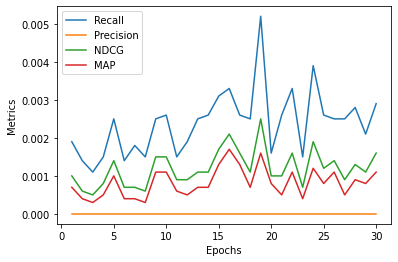

In [ ]:
epoch_list = [(i + 1) for i in range(epochs)]
plt.plot(epoch_list, recall_list, label = 'Recall')
plt.plot(epoch_list, precision_list, label = 'Precision')
plt.plot(epoch_list, ndcg_list, label = 'NDCG')
plt.plot(epoch_list, map_list, label = 'MAP')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

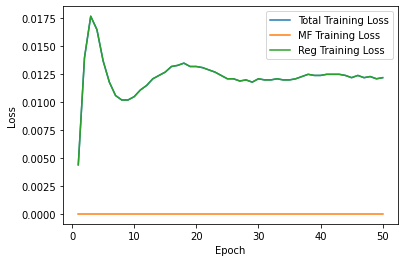

In [ ]:
plt.plot(epoch_list, loss_list_epoch, label = "Total Training Loss")
plt.plot(epoch_list, mf_loss_list_epoch, label = "MF Training Loss")
plt.plot(epoch_list, reg_loss_list_epoch, label = "Reg Training Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("Average time taken to train an epoch --> ", round(np.mean(train_time_list), 2), " seconds")
print("Average time taken to evaluate an epoch --> ", round(np.mean(eval_time_list), 2), " seconds")

Average time taken to train an epoch -->  15.17  seconds
Average time taken to evaluate an epoch -->  2.27  seconds


In [ ]:
print("Last Epoch's Test Data Recall --> ", recall_list[-1])
print("Last Epoch's Test Data Precision --> ", precision_list[-1])
print("Last Epoch's Test Data NDCG --> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP --> ", map_list[-1])

print("Last Epoch's Train Data Loss --> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall -->  0.0006
Last Epoch's Test Data Precision -->  0
Last Epoch's Test Data NDCG -->  0.0005
Last Epoch's Test Data MAP -->  0.0003
Last Epoch's Train Data Loss -->  0.0023


In [ ]:
#Create the rating matrix
rating['reviewerID'] = rating['reviewerID'].astype('category')
rating['asin'] = rating['asin'].astype('category')
R = csr_matrix((rating['rating'].values, (rating['reviewerID'].cat.codes, rating['asin'].cat.codes)))
R.shape[1]
 
# Convert a sparse numpy object to a sparse pytorch tensor.
def to_sparse_tensor(X):
  """
  
  Note that the tensor does not yet live on the GPU
  """
  coo = X.tocoo().astype(np.float32)
  i = torch.LongTensor(np.mat((coo.row, coo.col)))
  v = torch.FloatTensor(coo.data)
  return torch.sparse.FloatTensor(i, v, coo.shape)
r = to_sparse_tensor(R)

rating.groupby(['rating'])['rating'].count() # Rating Distribution
rating['rating'].value_counts()

In [ ]:
import torch
from torch.autograd import Variable

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
	# create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
	# create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)

    def forward(self, user, item):
    	# matrix multiplication
        return (self.user_factors(user)*self.item_factors(item)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

In [ ]:
num_users = rating.reviewerID.nunique()
num_musics = rating.asin.nunique()

model = MatrixFactorization(num_users, num_musics, n_factors=20)
loss_fn = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

users = rating['reviewerID'].unique()
musics = rating['asin'].unique()

for user, item in zip(users, musics):
    # get user, item and rating data
    rating = Variable(torch.FloatTensor([R[user, item]]))
    user = Variable(torch.LongTensor([int(user)]))
    item = Variable(torch.LongTensor([int(item)]))

    # predict
    prediction = model(user, item)
    loss = loss_fn(prediction, rating)

    # backpropagate
    loss.backward()

    # update weights
    optimizer.step()

IndexError: ignored

In [ ]:
num_users = rating.reviewerID.nunique()
num_musics = rating.asin.nunique()

users = rating['reviewerID'].unique()
musics = rating['asin'].unique()

user_ids = range(num_users)
music_ids = range(num_musics)

user_to_id = dict(zip(users, user_ids))
music_to_id = dict(zip(musics, music_ids))

# initialize the adjacency matrix
rat = torch.zeros(num_users, num_musics)
for index, row in rating.iterrows():
  music, user, rating = row[:3]
  if num_users != -1:
    if user not in user_to_id: break
            # create ratings matrix where (i, j) entry represents the ratings
            # of movie j given by user i.
  rat[user_to_id[user], music_to_id[music]] = rating
rat

In [ ]:
from scipy.sparse import csr_matrix

# preprocess data
USER_COL = 'reviewerID'
ITEM_COL = 'asin'
RATING_COL = 'overall'

row = review[USER_COL]
col = review[ITEM_COL]
data = review[RATING_COL]
mat = csr_matrix((data, (row, col)), shape=(users, items))
mat.eliminate_zeros()
sparsity = float(len(mat.nonzero()[0]))
sparsity /= (mat.shape[0] * mat.shape[1])
sparsity

ValueError: ignored

In [ ]:
review['reviewTime'] = pd.to_datetime(review['reviewTime'])
review['year'] = review['reviewTime'].dt.year

0          2013
1          2013
2          2013
3          2012
4          2012
           ... 
1584077    2018
1584078    2018
1584079    2017
1584080    2018
1584081    2017
Name: reviewTime, Length: 1584082, dtype: int64

In [ ]:
# Links for the 2014 version 
meta_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Digital_Music.json.gz"
ratings_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Digital_Music.csv"
reviews_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz"

columns = ['reviewrId', 'musicId', 'rating', 'reviewTime']

In [ ]:
music_reviews.rename(columns = {'reviewerID':'reviewerId', 'overall':'rating', 'asin':'musicId'}, inplace = True)
music_reviews.head(2)

,reviewerId,musicId,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5,Enya at her most elegant,991526400,"06 3, 2001"


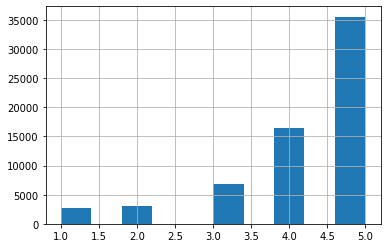

In [ ]:
music_reviews['rating'].hist()